In [439]:
import httplib2
import oauth2
import urllib3
import types
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from gender_detector import GenderDetector 
import psycopg2, psycopg2.extras
from causalinference import CausalModel
from causalinference.utils import random_data
import httplib
import base64
import json # For Microsoft Face API
import urllib as urllib # For Microsoft Face API
import time 
import csv
import datetime 
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Initialize arrays for Causal Analysis 
user_count = 1
bill_rate_array = []
gender_array = []
all_covariates_array = []

# Read data from csv files and reformat
df = pd.read_csv(all_data_file_name)
df_gender = pd.read_csv(gender_data_file_name)

# Merge the files, then remove rows with an error, no gender identified, or ambiguous education
merged = df.merge(df_gender, on='user_count')
merged = merged[merged.bill_rate != 'error']
merged = merged[merged.gender != 'unidentified']
merged = merged[merged.gender != 'error']
merged = merged[merged.education != 'None']
#merged = merged[merged.country == 'United Kingdom']
merged = merged[merged.job_category != 'none']
#merged = merged[merged.job_category != 'Legal']
#merged = merged[merged.job_category == 'Writing']
#merged = merged[merged.education != 'Doctorate']
#merged = merged[merged.education != 'High School']
#merged = merged[merged.education != 'Professional']

all_bill_rates = merged.bill_rate.astype('float')
merged['bill_rate'] = merged.bill_rate.astype('float')
merged['work_experience'] = merged.work_experience.astype('float')
all_work_experience = merged.work_experience
all_education = merged.education
all_job_category_id = merged.job_category_id
all_country_id = merged.country_id
all_genders = merged.gender
        
# Data formatting 
for gender in all_genders:
    if (gender == "female"):
        gender_array.append(1)
    elif (gender == "male"):
        gender_array.append(2)

for rate in all_bill_rates:
    rate = round(float(rate), 2)
    bill_rate_array.append(rate)

for row in merged.itertuples():
    covariate_matrix = [row.job_category_id]
    all_covariates_array.append(covariate_matrix)
        
# Check that arrays contain complete data
print "Bill rate array length: {0}".format(len(bill_rate_array))
print "Gender array length: {0}".format(len(gender_array))
print "Covariate array length: {0}".format(len(all_covariates_array))


Bill rate array length: 7292
Gender array length: 7292
Covariate array length: 7292


In [440]:
# See distribution of job categories

job_category_table = pd.crosstab(merged['job_category'], merged['gender'])
print job_category_table

gender                      female  male
job_category                            
Accounting & Consulting         85   116
Admin Support                  373   326
Customer Service                66    70
Data Science & Analytics        38   177
Design & Creative              592  1031
Engineering & Architecture      69   211
IT & Networking                 23   205
Legal                           12    17
Sales & Marketing              158   214
Translation                    347   334
Web, Mobile & Software Dev     263  1756
Writing                        419   390


In [441]:
# Make a crosstabs
gender_table= merged.groupby('gender')['bill_rate'].mean()
print gender_table

gender_table= merged.groupby('job_category')['bill_rate'].mean()
print gender_table

gender_table= merged.groupby('gender')['bill_rate'].std()
print gender_table

gender
female    23.021333
male      24.284062
Name: bill_rate, dtype: float64
job_category
Accounting & Consulting       41.006418
Admin Support                 14.608026
Customer Service              13.385809
Data Science & Analytics      29.507023
Design & Creative             24.835280
Engineering & Architecture    21.476429
IT & Networking               27.793333
Legal                         64.149310
Sales & Marketing             30.647742
Translation                   17.514170
Web, Mobile & Software Dev    23.818747
Writing                       26.499135
Name: bill_rate, dtype: float64
gender
female    21.152882
male      27.134005
Name: bill_rate, dtype: float64


In [442]:
# See distribution for our covariates

education_table = pd.crosstab(merged['education'], merged['gender'])
print education_table

gender        female  male
education                 
Associate         95   151
Bachelor        1403  2709
Doctorate         31    90
High School       45   139
Master           803  1673
Professional      68    85


In [443]:
# Run causal analysis 
Y = np.array(bill_rate_array)
D = np.array(gender_array)
X = np.array(all_covariates_array)

causal = CausalModel(Y, D, X)
causal.est_via_matching()
print(causal.estimates)

ValueError: Too few control units: N_c < K+1

In [444]:
print np.mean(bill_rate_array)

23.8606705979


In [445]:
print all_bill_rates.std()

25.2922389975


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe16650710>]], dtype=object)

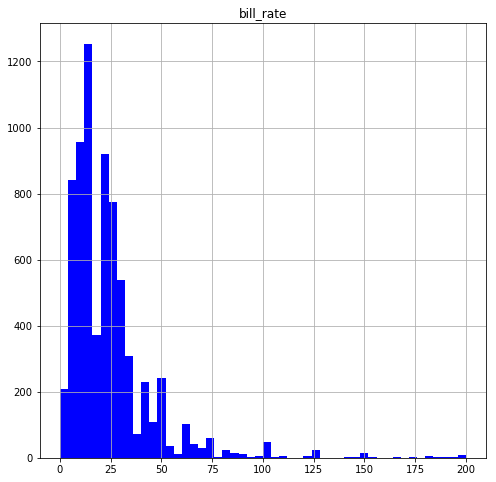

In [446]:
# Plot a histogram of bill rate

merged.hist(column='bill_rate', figsize=(8,8), color="blue", bins=50, range=(0,200))

col_0                             count
country                                
United States                      1360
India                               836
Ukraine                             666
Philippines                         530
Russia                              351
Pakistan                            317
Serbia                              217
Bangladesh                          216
United Kingdom                      215
Egypt                               192
Romania                             133
Canada                              118
Australia                            97
Italy                                84
Germany                              84
France                               76
Indonesia                            72
Brazil                               66
Armenia                              62
Bulgaria                             62
Macedonia                            62
Spain                                57
Greece                               56


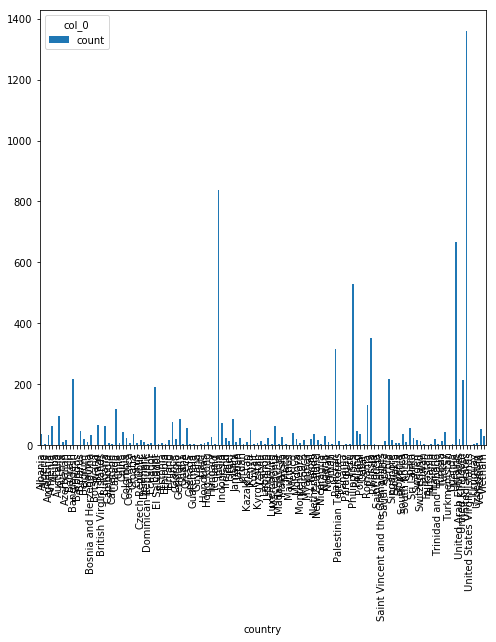

In [447]:
# Plot a bar chart of countries

country_table = pd.crosstab(index=merged['country'], columns="count")
print country_table.sort_values(by=['count'], ascending=False)
country_table.plot(kind="bar", figsize=(8,8))

## We find that the top 10 countries represented are United States, India, Ukraine, Philippines, 
## Russia, Pakistan, Serbia, United Kingdom
## Bangladesh, and Egypt 

In [448]:
# Plot bill rate by country 

col_0            count
work_experience       
-1.0                 1
 0.0              1787
 1.0               647
 2.0               691
 3.0               641
 4.0               645
 5.0               470
 6.0               409
 7.0               368
 8.0               265
 9.0               284
 10.0              194
 11.0              166
 12.0              107
 13.0               84
 14.0               85
 15.0               66
 16.0               56
 17.0               51
 18.0               53
 19.0               36
 20.0               19
 21.0               34
 22.0               24
 23.0                9
 24.0               10
 25.0               16
 26.0                9
 27.0                7
 28.0                6
 29.0                8
 30.0                6
 31.0                2
 32.0                1
 33.0                6
 34.0                4
 35.0                5
 36.0                4
 37.0                3
 38.0                3
 39.0                2
 41.0      

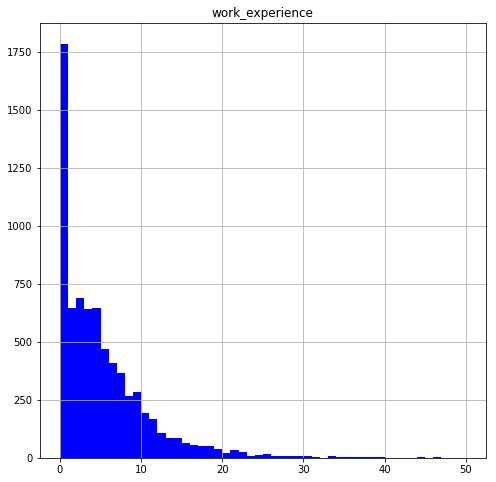

In [449]:
# Get work experience distribution 
merged.hist(column='work_experience', figsize=(8,8), color="blue", bins=50, range=(0,50))
work_experience_table = pd.crosstab(index=merged['work_experience'], columns="count")
print work_experience_table

In [450]:
# Computing statistical significance of bill rate between men and women on Upwork worldwide
model = ols("bill_rate ~ gender", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print anova_table

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.053
Date:                Wed, 22 Nov 2017   Prob (F-statistic):             0.0441
Time:                        13:28:11   Log-Likelihood:                -33901.
No. Observations:                7292   AIC:                         6.781e+04
Df Residuals:                    7290   BIC:                         6.782e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         23.0213      0.511     45.

In [451]:
# Computing statistical significance of bill rate between people from different job categories on Upwork worldwide
model = ols("bill_rate ~ job_category", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print anova_table

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     36.64
Date:                Wed, 22 Nov 2017   Prob (F-statistic):           2.42e-77
Time:                        13:28:11   Log-Likelihood:                -33707.
No. Observations:                7292   AIC:                         6.744e+04
Df Residuals:                    7280   BIC:                         6.752e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [452]:
# Computing statistical significance of bill rate between people with different education on Upwork worldwide
model = ols("bill_rate ~ education", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print anova_table

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.15
Date:                Wed, 22 Nov 2017   Prob (F-statistic):           1.00e-10
Time:                        13:28:11   Log-Likelihood:                -33875.
No. Observations:                7292   AIC:                         6.776e+04
Df Residuals:                    7286   BIC:                         6.780e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [453]:
# Computing statistical significance of bill rate between people with different education on Upwork worldwide
model = ols("bill_rate ~ job_category_id + education + gender + work_experience", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print anova_table

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     28.78
Date:                Wed, 22 Nov 2017   Prob (F-statistic):           1.45e-44
Time:                        13:28:12   Log-Likelihood:                -33790.
No. Observations:                7292   AIC:                         6.760e+04
Df Residuals:                    7283   BIC:                         6.766e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             